In [171]:
import numpy as np
from math import pi, sqrt, tanh
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from scipy.optimize import minimize
import time
from ipywidgets import interact

# fundamental constants
hbar=1.05e-34
elec=1.6e-19
meV=elec*1e-3

In [66]:
# parameters

vF=1e6
B=10 # Tesla
hwc=vF*sqrt(2*hbar*elec*B)
lB=np.sqrt(hbar/(elec*B))
m_sc=3*hwc #1e2*meV
mu_sc=8*hwc #1e2*meV
D1=0.5*hwc #10*meV
D2=0.6*hwc #10*meV
nu=1.2#sqrt(2)+0.1
mu_n=nu*hwc #10*meV
m_n=0.1*hwc

lRx= 1*hwc
lRy= 0.*hwc
lso= 0.*hwc
# lam=0.5*vF
gs=0.0*hwc
gn=0.3*hwc

Ls=6*lB
Lx=8*lB

In [6]:
# new parameters

vF=1e6
B=6 # Tesla
hwc=vF*sqrt(2*hbar*elec*B)
lB=np.sqrt(hbar/(elec*B))
# print(lB)
m_sc=3*hwc #1e2*meV
mu_sc=8*hwc #1e2*meV
D1=0.2*hwc #10*meV
D2=0.2*hwc #10*meV
nu=0.003#sqrt(2)+0.1
mu_n=nu*hwc #10*meV
m_n=0.001*hwc

lRx= 0.1*hwc
lRy= 0.*hwc
lso= 0.*hwc
# lam=0.5*vF
gs=0.0*hwc
gn=0.003*hwc

Ls=8*lB
Lx=12*lB

In [230]:
# newest parameters

vF=1e6
B=6 # Tesla
hwc=vF*sqrt(2*hbar*elec*B)
lB=np.sqrt(hbar/(elec*B))
m_sc=3*hwc 
mu_sc=8*hwc 
D1=0.3*hwc 
D2=0.2*hwc 
m_n=0.06*hwc

lRx= 0.2*hwc 
lRy= 0.*hwc
lso= 0.*hwc
gs=0.0*hwc
gn=0.2*hwc
nu= 0.45 # nu=2
# nu=1.2 # nu=6
mu_n=nu*hwc #10*meV


Ls=6*lB
Lx=8*lB
print(Ls*1e9,6/3.5,hwc/elec*1e3)

62.74950199005567 1.7142857142857142 88.74119674649424


In [231]:
ky_sw=np.linspace(0,1,100)*1/lB

Nx=100
kx=2*pi*np.arange(Nx)/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)
[k1,k2]=2*pi*np.mgrid[range(Nx),range(Nx)]/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)


def y2(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c= np.exp(1j*k*Ls/2)*(-2j+np.exp(1j*k*Lx)*(2j+ 2*k*Lx- 1j* k**2 * Lx**2))/ (k**3) /(2*Lx+Ls)
        c[ ~ np.isfinite( c )] = Lx**3 /(3*(2*Lx+Ls))
    return c

def y1(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx)*(1- 1j* k * Lx))/ (k**2) /(2*Lx+Ls)
        c[ ~ np.isfinite( c )] = Lx**2 /(2*(2*Lx+Ls))
    return c

def y0(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = -1j*np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx) )/(k*(2*Lx+Ls))
        c[ ~ np.isfinite( c )] = Lx /(2*Lx+Ls)
    return c

def y0s(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = 2*np.sin(k*Ls/2)/(k*(2*Lx+Ls))
        c[ ~ np.isfinite( c )] = Ls /(2*Lx+Ls)
    return c

sigma0=np.array([[1,0],[0,1]])
sigma1=np.array([[0,1],[1,0]])
sigma2=np.array([[0,-1j],[1j,0]])
sigma3=np.array([[1,0],[0,-1]])
s00=np.kron(sigma0,sigma0)
s30=np.kron(sigma3,sigma0)
s01=np.kron(sigma0,sigma1)
s02=np.kron(sigma0,sigma2)


Hx= hbar*vF*np.kron(s30, np.kron(np.diag(kx) , sigma1))
HeB= 2j*vF*elec*B* np.kron(np.imag(y1(k1-k2)), sigma2)
HeBT= 2j*vF*elec*B* np.kron(np.imag(y1(k2-k1)), sigma2)

Hxm= np.kron( m_sc*y0s(k1-k2)+2*m_n*np.real(y0(k1-k2)) , sigma3)
HxmT= np.kron( m_sc*y0s(k2-k1)+2*m_n*np.real(y0(k2-k1)) , sigma3)
Hlx= np.kron(np.kron(sigma3,sigma2),np.kron( y0s(k1-k2) , lRx*sigma1)) #1
HlxT= np.kron(np.kron(sigma3,sigma2),np.kron( y0s(k2-k1) , lRx*sigma1)) #1
Hly= -np.kron(np.kron(sigma0,sigma1),np.kron( y0s(k1-k2) , lRy*sigma2)) #2
HlyT= -np.kron(np.kron(sigma0,sigma1),np.kron( y0s(k2-k1) , lRy*sigma2)) #2
Hlz= np.kron(np.kron(sigma3,sigma3),np.kron( y0s(k1-k2) , lso*sigma3)) # 333
HlzT= np.kron(np.kron(sigma3,sigma3),np.kron( y0s(k2-k1) , lso*sigma3))
Hl=Hlx+Hly+Hlz
HlT=HlxT+HlyT+HlzT
# Hlx=hbar*lam*np.kron(s02, np.kron( (k1+k2)/2*y0s(k1-k2),sigma0) )
# HlxT=-hbar*lam*np.kron(s02, np.kron((k1+k2)/2*y0s(k2-k1),sigma0) )

Hef= -np.kron( 2*mu_n*np.real(y0(k1-k2)) + mu_sc*y0s(k1-k2), sigma0 )
HefT= -np.kron( 2*mu_n*np.real(y0(k2-k1)) + mu_sc*y0s(k2-k1), sigma0 )

Hd= np.kron(y0s(k1-k2),sigma0)
# basis ud,ud
# dmat1=np.kron(np.array([[0.,1j],[0.,0.]]),sigma1)
# ddmat1=np.kron(dmat1,sigma2) 
dmat2=np.kron(np.array([[0.,1j],[0.,0.]]),D1*sigma1+D2*sigma0)
ddmat2=np.kron(dmat2,sigma2)
Hd_mat=np.kron(ddmat2,Hd)
Hd_mat=Hd_mat+np.transpose(Hd_mat).conj()

s03=np.kron(sigma0,sigma3)
Hz_up= -(gs*y0s(k1-k2)+2*gn*np.real(y0(k1-k2)))
Hz= np.kron(s03, np.kron(Hz_up,sigma0) )
Hz_upT= -(gs*y0s(k2-k1)+2*gn*np.real(y0(k2-k1)))
HzT= np.kron(s03, np.kron(Hz_upT,sigma0) )


Vn=np.zeros((16*Nx,16*Nx,len(ky_sw)), dtype=np.complex64)
En=np.zeros((16*Nx,len(ky_sw)))
for i_y in range(len(ky_sw)):
    ky=ky_sw[i_y]
    Hy= hbar*vF*ky*np.kron(np.eye(Nx), sigma2)

#     Hly=hbar*lam*ky*np.kron(s01, np.kron(y0s(k1-k2),sigma0) )
#     HlyT=-hbar*lam*ky*np.kron(s01, np.kron(y0s(k2-k1),sigma0) )

    H1 = Hx + np.kron(s00, Hy+ HeB + Hxm + Hef)+ Hz + Hl
    H1T = -Hx  + np.kron(s00,Hy+ (HeBT + HxmT + HefT).conj())+ (HzT+HlT).conj()

    H_t=block_diag(H1,-H1T)+Hd_mat
#     En[:,i_y], Vn[:,:,i_y] =np.linalg.eigh(H_t)
    En[:,i_y] =np.linalg.eigvalsh(H_t)


# out_dir = 'LL_bands/' 
# f1= 'nu_%.2f_Lxs_%d_%d_Nx_%d.npz' % (nu,Lx/lB,Ls/lB,Nx)
# fname = out_dir+f1
# np.savez(fname, kps=ky_sw , En=En, evecs=Vn[:,8*Nx-1:8*Nx+1,:])

print("Done!")

Done!


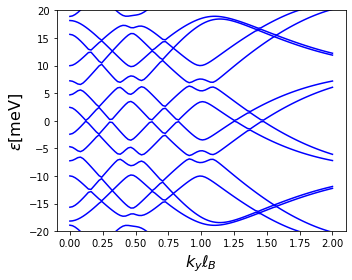

In [52]:
##### plot for notes

plt.figure(figsize=(5,4))
plt.plot(ky_sw*lB,En.T/elec*1e3,'b')

fsize=16
# plt.ylabel(r"$\varepsilon/\varepsilon_0$",fontsize = fsize)
plt.ylabel(r"$\varepsilon$[meV]",fontsize = fsize)
plt.xlabel(r"$k_y \ell_B$",fontsize = fsize)
plt.ylim(-20,20)
# plt.xlim(0.2,1.7)
# plt.xlim(-1,4)
# plt.xticks(np.arange(-4,4.1,2))
# plt.yticks(np.arange(-2,2.1,1))
# plt.legend(loc='upper right')
plt.tight_layout()
# plt.savefig('figs/TS_Hoppe_Nx_%d_nu_%.2f.pdf' % (Nx,nu))
plt.show()

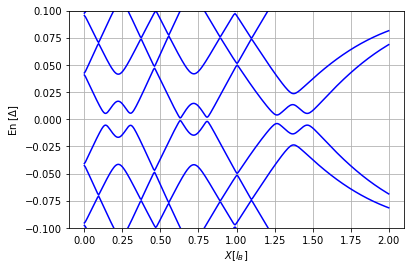

In [194]:
# plt.figure()
plt.plot(ky_sw*lB,En.T/hwc,'b')
# plt.plot(ky_sw*lB,En.T/D1,'b')
plt.ylabel(r"En [$\Delta$]")
plt.xlabel(r"$X[l_B]$")

# Nll=4
# ill=np.arange(Nll)
# E1=np.reshape(np.sqrt(ill+(m_n/hwc)**2),[1,Nll])
# Eplot= np.concatenate((E1,E1),axis=0)
# xvals=np.reshape(np.array([2.5,3.5]),[2,1])
# plt.plot(xvals, Eplot-mu_n/hwc-gn/hwc,'k--')
# plt.plot(xvals, Eplot-mu_n/hwc+gn/hwc,'k--')
# plt.plot(xvals, -Eplot+mu_n/hwc-gn/hwc,'k--')
# plt.plot(xvals, -Eplot+mu_n/hwc+gn/hwc,'k--')


plt.ylim(-.1,.1)
# plt.ylim(-0.015,0.015)
# plt.ylim(-.002,.002)
plt.grid()

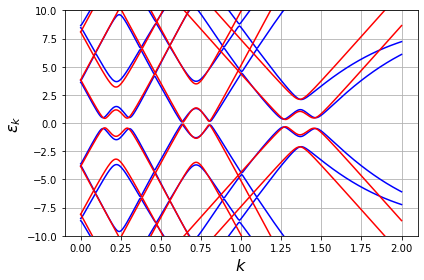

In [198]:
# nu=6 effective theory fit

# plt.figure()
plt.plot(ky_sw*lB,En.T/meV,'b')
# plt.plot(ky_sw*lB,En.T/D1,'b')
plt.ylabel(r"En [$\Delta_1$]")
plt.xlabel(r"$k_y \ell_B$")
cursor = Cursor(ax, useblit=True, color='red', linewidth=2)

y0=0.4

plt.ylim(-y0,y0)
# plt.ylim(-0.015,0.015)
# plt.ylim(-.002,.002)
# plt.grid()

# nu=6 

vF=1
vF_6=0.6
k0s= np.array([0.14,0.3,0.629,0.81,vF_6*1.27,vF_6*1.46])
k0= np.diag(np.kron([1,1],k0s))

D1_eff=0.018
D2=0.0188
D3=0.004
D4=0.0066
D5=0.013
D6=0.018
D12=0.038
D23=0.0
D34=0.04
D45=0.
D56=0.02


# dmat= np.zeros((6,6))
dmat= np.array([[D1_eff,D12,0,0,0,0],
                [D12,D2,D23,0,0,0],
                [0,D23,D3,D34,0,0],
                [0,0,D34,D4,D45,0],
                [0,0,0,D45,D5,D56],
                [0,0,0,0,D56,D6]])
Hd=np.block([
    [np.zeros((6,6)), dmat],
    [-dmat, np.zeros((6,6))]
])

k_sw= np.linspace(0,1,401)*2
En1= np.zeros((len(k_sw),24))
for i_k in range(len(k_sw)):

    Hp= vF*k_sw[i_k]*np.diag(np.concatenate((np.ones(4),vF_6*np.ones(2),-np.ones(4),-vF_6*np.ones(2))))\
         -vF*k0
    HpT= -vF*k_sw[i_k]*np.diag(np.concatenate((np.ones(4),vF_6*np.ones(2),-np.ones(4),-vF_6*np.ones(2))))\
         -vF*k0
    H1= np.block([
        [Hp, Hd],
        [np.matrix(Hd).H, -HpT]
    ])
    En1[i_k,:], _ = np.linalg.eigh(H1)


# plt.figure()#figsize=(4,4))
plt.plot(k_sw,En1*D1/meV,'r')#,'o',markersize=1)

plt.xlabel('k')
plt.ylabel('E')
fsize=16
plt.ylabel(r"$\varepsilon_k$",fontsize = fsize)
plt.xlabel(r"$k$",fontsize = fsize)
plt.ylim(-10,10)
# plt.xlim(-1,4)
# plt.xticks([0,2,4])
# plt.yticks(np.arange(-2,2.1,1))
plt.grid()
plt.tight_layout()
# plt.savefig('figs/nu2_eff_D12_%d_%d.pdf' % (100*D1,100*D2))
plt.show()



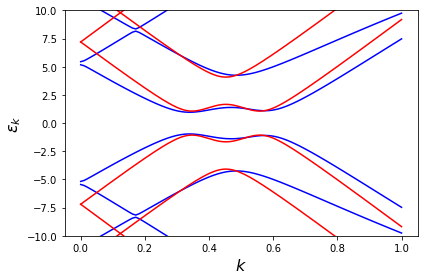

In [232]:
# nu=2 effective theory fit
# nu=2 warm up

# plt.figure()
plt.plot(ky_sw*lB,En.T/meV,'b')
# plt.plot(ky_sw*lB,En.T/D1,'b')
plt.ylabel(r"En [$\Delta_1$]")
plt.xlabel(r"$k_y \ell_B$")
cursor = Cursor(ax, useblit=True, color='red', linewidth=2)

y0=0.4

plt.ylim(-y0,y0)

D1_eff=0.04
D12= 0.05
D2_eff=0.04
k0u=0.575
k0d=0.33
vF=0.8

dmat= np.zeros((2,2))
dmat[0,0]= D1_eff
dmat[0,1]= D12
dmat[1,0]= -D12
dmat[1,1]= D2_eff
Hd=np.block([
    [np.zeros((2,2)), dmat],
    [-dmat, np.zeros((2,2))]
])

k_sw= np.linspace(0,1,4001)*1
En1= np.zeros((len(k_sw),8))
for i_k in range(len(k_sw)):
    Hp= vF*k_sw[i_k]*np.diag(np.concatenate((np.ones(2),-np.ones(2))))\
        -vF*np.diag([k0u,k0d,k0u,k0d])
    HpT= -vF*k_sw[i_k]*np.diag(np.concatenate((np.ones(2),-np.ones(2))))\
        -vF*np.diag([k0u,k0d,k0u,k0d])
    H1= np.block([
        [Hp, Hd],
        [np.matrix(Hd).H, -HpT]
    ])
    En1[i_k,:], _ = np.linalg.eigh(H1)

    
plt.plot(k_sw,En1*D1/meV,'r')

plt.xlabel('k')
plt.ylabel('E')
fsize=16
plt.ylabel(r"$\varepsilon_k$",fontsize = fsize)
plt.xlabel(r"$k$",fontsize = fsize)
plt.ylim(-10,10)
# plt.xlim(-1,4)
# plt.xticks([0,2,4])
# plt.yticks(np.arange(-2,2.1,1))
# plt.grid()
plt.tight_layout()
# plt.savefig('figs/nu2_eff_D12_%d_%d.pdf' % (100*D1,100*D2))
plt.show()



In [196]:
# import plotly.express as px

# fig = px.line(ky_sw*lB,En[8*Nx,:]/D1)
import plotly.graph_objects as go
from plotly.subplots import make_subplots

layout = go.Layout(
        yaxis=dict(
            range=[-0.4, 0.4]
        )
    )

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
for i_n in range(-3,3):
    fig.add_trace(
        go.Scatter(x=ky_sw*lB,y=En[8*Nx+i_n,:]/meV, name="yaxis data"),
        secondary_y=False
    )



# Set x-axis title
fig.update_xaxes(title_text="xaxis title")

# Set y-axes titles
fig.update_yaxes(title_text="<b>primary</b> yaxis title", secondary_y=False)
# fig.update_yaxes(title_text="<b>secondary</b> yaxis title", secondary_y=True)
fig.update_yaxes(range=[0, 10], row=1, col=1)

fig.show()

In [228]:
# import plotly.express as px

# fig = px.line(ky_sw*lB,En[8*Nx,:]/D1)
import plotly.graph_objects as go
from plotly.subplots import make_subplots

layout = go.Layout(
        yaxis=dict(
            range=[-0.4, 0.4]
        )
    )

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
for i_n in range(-3,3):
    fig.add_trace(
        go.Scatter(x=ky_sw*lB,y=En[8*Nx+i_n,:]/meV, name="yaxis data"),
        secondary_y=False
    )



# Set x-axis title
fig.update_xaxes(title_text="xaxis title")

# Set y-axes titles
fig.update_yaxes(title_text="<b>primary</b> yaxis title", secondary_y=False)
# fig.update_yaxes(title_text="<b>secondary</b> yaxis title", secondary_y=True)
fig.update_yaxes(range=[0, 10], row=1, col=1)

fig.show()

In [127]:
import plotly
import plotly.graph_objs as go

# Create random data with numpy
import numpy as np

N = 1000
random_x = np.random.randn(N)
random_y = np.random.randn(N)

# Create a trace
trace = go.Scatter(
    x = random_x,
    y = random_y,
    mode = 'markers'
)
data = [trace]

# Plot and embed in ipython notebook!
plotly.offline.plot(data, filename='basic-scatter')

'basic-scatter.html'

In [106]:
def wf_real_space(ev,k,x,Ls):
    Nx=len(k)
    kt=np.reshape(k,[1,Nx])
    xt=np.reshape(x,[len(x),1])
    
    ev_p= ev[:8*Nx,:]
    ev_p_K1 = ev_p[:4*Nx,:]
    ev_p_K2 = ev_p[4*Nx:,:]
    ev_h= ev[8*Nx:,:]
    ev_h_K1 = ev_h[:4*Nx,:]
    ev_h_K2 = ev_h[4*Nx:,:]
    ## uA # uB # dA # dB
    return np.dot(np.exp(1j*kt*xt),ev_p_K1[0:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p_K1[1:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p_K1[2*Nx:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p_K1[2*Nx+1:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p_K2[0:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p_K2[1:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p_K2[2*Nx:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p_K2[2*Nx+1:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h_K1[0:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h_K1[1:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h_K1[2*Nx:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h_K1[2*Nx+1:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h_K2[0:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h_K2[1:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h_K2[2*Nx:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h_K2[2*Nx+1:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0])


def plot_wf(i_band=Nx,iwf=int(len(ky_sw)/2)):
# iwf=0
    plt.figure(figsize=(10,10))
    plt.subplot(3,2,1)
    plt.plot(ky_sw*lB,En.T/hwc,'b')
    plt.plot(ky_sw[iwf]*lB,En[i_band,iwf]/hwc,'ro')
    plt.ylabel("Energy(meV)")
    plt.xlabel("X(l)")
    plt.ylim(-0.1,0.1)
    # plt.xlim(-7.5,7.5)
    plt.grid()
#     plt.show()
    plt.tight_layout()


    x0=np.linspace(-1,1,500)*8*lB
    wfpK1_uA,wfpK1_uB, wfpK1_dA,wfpK1_dB,\
    wfpK2_uA,wfpK2_uB, wfpK2_dA,wfpK2_dB,\
    wfhK1_uA,wfhK1_uB, wfhK1_dA,wfhK1_dB,\
    wfhK2_uA,wfhK2_uB, wfhK2_dA,wfhK2_dB =wf_real_space(np.reshape(Vn[:,i_band,:],[16*Nx,len(ky_sw)]),kx,x0,Ls)
#     plt.figure()
    plt.title('ky=%.2f' % (ky_sw[iwf]*lB) )
    plt.subplot(3,2,3)
    plt.title('K1')
    plt.plot(x0/lB,np.abs(wfpK1_uA[:,iwf])**2,label=r'$eA\uparrow$')
    plt.plot(x0/lB,np.abs(wfpK1_uB[:,iwf])**2,label=r'$eB\uparrow$')
    plt.plot(x0/lB,np.abs(wfpK1_dA[:,iwf])**2,label=r'$eA\downarrow$')
    plt.plot(x0/lB,np.abs(wfpK1_dB[:,iwf])**2,label=r'$eB\downarrow$')
#     plt.ylim(-0.001,0.01)
    plt.tight_layout()


    plt.legend()
    plt.subplot(3,2,4)
    plt.title('K1')
    plt.plot(x0/lB,np.abs(wfhK1_uA[:,iwf])**2,label=r'$hA\uparrow$')
    plt.plot(x0/lB,np.abs(wfhK1_uB[:,iwf])**2,label=r'$hB\uparrow$')
    plt.plot(x0/lB,np.abs(wfhK1_dA[:,iwf])**2,label=r'$hA\downarrow$')
    plt.plot(x0/lB,np.abs(wfhK1_dB[:,iwf])**2,label=r'$hB\downarrow$')
#     plt.ylim(-0.001,0.01)
    plt.tight_layout()


    plt.legend()
    plt.subplot(3,2,5)
    plt.title('K2')
    plt.plot(x0/lB,np.abs(wfpK2_uA[:,iwf])**2,label=r'$eA\uparrow$')
    plt.plot(x0/lB,np.abs(wfpK2_uB[:,iwf])**2,label=r'$eB\uparrow$')
    plt.plot(x0/lB,np.abs(wfpK2_dA[:,iwf])**2,label=r'$eA\downarrow$')
    plt.plot(x0/lB,np.abs(wfpK2_dB[:,iwf])**2,label=r'$eB\downarrow$')
#     plt.ylim(-0.001,0.01)
    plt.tight_layout()


    plt.legend()
    plt.subplot(3,2,6)
    plt.title('K2')
    plt.plot(x0/lB,np.abs(wfhK2_uA[:,iwf])**2,label=r'$hA\uparrow$')
    plt.plot(x0/lB,np.abs(wfhK2_uB[:,iwf])**2,label=r'$hB\uparrow$')
    plt.plot(x0/lB,np.abs(wfhK2_dA[:,iwf])**2,label=r'$hA\downarrow$')
    plt.plot(x0/lB,np.abs(wfhK2_dB[:,iwf])**2,label=r'$hB\downarrow$')
#     plt.ylim(-0.001,0.01)
    plt.tight_layout()


    plt.legend()

    plt.show()

interact(plot_wf,iwf=(0,len(ky_sw)-1,1), i_band=range(8*Nx-int(nu**2)-1,8*Nx+int(nu**2)+1));
#, continuous_update=False);

interactive(children=(Dropdown(description='i_band', options=(798, 799, 800, 801), value=798), IntSlider(value…

SC spectrum

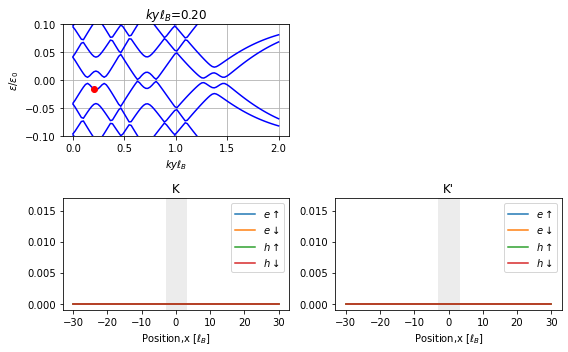

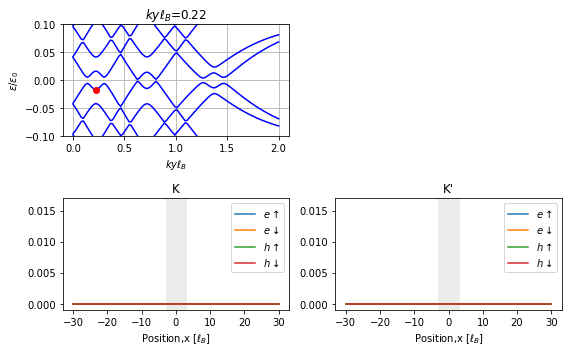

In [86]:
def wf_real_space(ev,k,x,Ls):
    Nx=len(k)
    kt=np.reshape(k,[1,Nx])
    xt=np.reshape(x,[len(x),1])
    
    ev_p= ev[:8*Nx,:]
    ev_p_K1 = ev_p[:4*Nx,:]
    ev_p_K2 = ev_p[4*Nx:,:]
    ev_h= ev[8*Nx:,:]
    ev_h_K1 = ev_h[:4*Nx,:]
    ev_h_K2 = ev_h[4*Nx:,:]
    ## uA # uB # dA # dB
    return np.dot(np.exp(1j*kt*xt),ev_p_K1[0:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p_K1[1:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p_K1[2*Nx:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p_K1[2*Nx+1:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p_K2[0:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p_K2[1:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p_K2[2*Nx:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p_K2[2*Nx+1:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h_K1[0:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h_K1[1:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h_K1[2*Nx:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h_K1[2*Nx+1:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h_K2[0:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h_K2[1:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h_K2[2*Nx:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h_K2[2*Nx+1:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0])


def plot_wf(i_band=Nx,iwf=int(len(ky_sw)/2)):
# iwf=0
    plt.figure(figsize=(8,5))
    plt.subplot(2,2,1)
    plt.plot(ky_sw*lB,En.T/hwc,'b')
    plt.plot(ky_sw[iwf]*lB,En[i_band,iwf]/hwc,'ro')
    plt.ylabel(r"$\varepsilon/\varepsilon_0$")
    plt.xlabel("$ky \ell_B$")
    plt.ylim(-0.1,0.1)
    # plt.xlim(-7.5,7.5)
    plt.grid()
#     plt.show()
    plt.tight_layout()


    x0=np.linspace(-1,1,500)*30*lB
    wfpK1_uA,wfpK1_uB, wfpK1_dA,wfpK1_dB,\
    wfpK2_uA,wfpK2_uB, wfpK2_dA,wfpK2_dB,\
    wfhK1_uA,wfhK1_uB, wfhK1_dA,wfhK1_dB,\
    wfhK2_uA,wfhK2_uB, wfhK2_dA,wfhK2_dB =wf_real_space(np.reshape(Vn[:,i_band,:],[16*Nx,len(ky_sw)]),kx,x0,Ls)
#     plt.figure()
    plt.title(r'$ky \ell_B$=%.2f' % (ky_sw[iwf]*lB) )
    plt.subplot(2,2,3)
    plt.title('K')
    wfpK1_u=np.abs(wfpK1_uA[:,iwf])**2+np.abs(wfpK1_uB[:,iwf])**2
    wfpK1_d=np.abs(wfpK1_dA[:,iwf])**2+np.abs(wfpK1_dB[:,iwf])**2
    wfhK1_u=np.abs(wfhK1_uA[:,iwf])**2+np.abs(wfhK1_uB[:,iwf])**2
    wfhK1_d=np.abs(wfhK1_dA[:,iwf])**2+np.abs(wfhK1_dB[:,iwf])**2

    plt.plot(x0/lB,wfpK1_u,label=r'$e \uparrow$')
    plt.plot(x0/lB,wfpK1_d,label=r"$e \downarrow$")
    plt.plot(x0/lB,wfhK1_u,label=r'$h \uparrow$')
    plt.plot(x0/lB,wfhK1_d,label=r"$h \downarrow$")
    ymax=0.017
    ymin=-0.001
    plt.fill([-Ls/lB/2,Ls/lB/2,Ls/lB/2,-Ls/lB/2],[ymax,ymax,ymin,ymin],c='#ECECEC')
    plt.ylim(ymin,ymax)
    plt.xlabel(r'Position,x [$\ell_B$]')
    plt.tight_layout()

    plt.legend()
    plt.subplot(2,2,4)
    plt.title("K'")
    wfpK2_u=np.abs(wfpK2_uA[:,iwf])**2+np.abs(wfpK2_uB[:,iwf])**2
    wfpK2_d=np.abs(wfpK2_dA[:,iwf])**2+np.abs(wfpK2_dB[:,iwf])**2
    wfhK2_u=np.abs(wfhK2_uA[:,iwf])**2+np.abs(wfhK2_uB[:,iwf])**2
    wfhK2_d=np.abs(wfhK2_dA[:,iwf])**2+np.abs(wfhK2_dB[:,iwf])**2

    plt.plot(x0/lB,wfpK2_u,label=r'$e \uparrow$')
    plt.plot(x0/lB,wfpK2_d,label=r"$e \downarrow$")
    plt.plot(x0/lB,wfhK2_u,label=r'$h \uparrow$')
    plt.plot(x0/lB,wfhK2_d,label=r"$h \downarrow$")
    plt.fill([-Ls/lB/2,Ls/lB/2,Ls/lB/2,-Ls/lB/2],[ymax,ymax,ymin,ymin],c='#ECECEC')
    plt.ylim(ymin,ymax)
    plt.xlabel(r'Position,x [$\ell_B$]')
    plt.tight_layout()

    plt.legend()
#     plt.show()
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(.1)

# interact(plot_wf,iwf=(0,len(ky_sw)-1,1), i_band=range(8*Nx-int(nu**2)-1,8*Nx+int(nu**2)+1));
# , continuous_update=False);

# plot_wf(i_band=8*Nx-1,iwf=23)

from IPython import display
for iwf in range(10,12):
    plot_wf(i_band=8*Nx-1,iwf=iwf)
